In [76]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [77]:
# 資料集獲取
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

# cache_subdir=''沒寫的話，就會下載到./datasets
# 這裡先不解壓縮
dataset=tf.keras.utils.get_file('stack_overflow_16k.tar.gz',origin=url,cache_dir='.',cache_subdir='datasets')

print(dataset)

.\datasets\stack_overflow_16k.tar.gz


In [78]:
# 檔案解壓
import tarfile

# open file
file = tarfile.open(dataset)

# extracting file
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')
file.extractall(dataset_dir)
print("已解壓到",dataset_dir)

file.close()


已解壓到 .\datasets\stack_overflow_16k


In [79]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [80]:
train_dir = os.path.join(dataset_dir, 'train')
print("train_dir: ",train_dir)
os.listdir(train_dir)

train_dir:  .\datasets\stack_overflow_16k\train


['csharp', 'java', 'javascript', 'python']

In [81]:
# 試著讀取資料
sample_file = os.path.join(train_dir, 'java/0.txt')
with open(sample_file) as f:
    print(f.read())

"how to download .msi file in blank i want to download .msi file using blank.  i have tried to download file using following code..printwriter out = null;.fileinputstream filetodownload = null;.bufferedreader bufferedreader = null;.try {.        out = response.getwriter();.        filetodownload = new fileinputstream(download_directory + file_name);.        bufferedreader = new bufferedreader(new inputstreamreader(filetodownload));..        //response.setcontenttype(""application/text"");.        //response.setcontenttype(""application/x-msi"");.        //response.setcontenttype(""application/msi"");.        //response.setcontenttype(""octet-stream"");.        response.setcontenttype(""application/octet-stream"");.        //response.setcontenttype(""application/x-7z-compressed"");.        //response.setcontenttype(""application/zip"");.        response.setheader(""content-disposition"",""attachment; filename="" +file_name );.        response.setcontentlength(filetodownload.available())

In [82]:
# 加載數據集
# train底下有四個語言，每個語言文件夾下有2000筆txt
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'datasets/stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)



Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [83]:
raw_train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [84]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])
        print()

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [85]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


接下來，創建一個驗證和測試數據集。將使用訓練集中剩餘的 1600 筆進行驗證。

In [86]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'datasets/stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [87]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'datasets/stack_overflow_16k/test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [88]:
# 準備數據集進行訓練

# 創建一個“TextVectorization”層
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [89]:
# 製作一個純文本數據集（沒有標籤），然後調用 adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

讓我們創建一個函數來查看使用該層預處理一些數據的結果。

In [90]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [91]:
# 從數據集中檢索一批（32 筆和標籤）
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [92]:
print("86 ---> ",vectorize_layer.get_vocabulary()[86])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

86 --->  program
 313 --->  source
Vocabulary size: 10000


In [93]:
# 將之前創建的 TextVectorization 層應用於訓練、驗證和測試數據集。
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [94]:
# 為性能配置數據集
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 創建模型

是時候創建你的神經網絡了：

將模型的最後一層修改為 Dense(4)，因為現在有四個輸出類。

In [95]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_6 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

### 損失函數和優化器

編譯模型時，將損失更改為 tf.keras.losses.SparseCategoricalCrossentropy。 這是用於多類分類問題的正確損失函數，當每個類的標籤都是整數時（在這種情況下，它們可以是 0、1、2 或 3）。 另外，將指標更改為metrics=['accuracy']，因為這是一個多類分類問題（tf.metrics.BinaryAccuracy 僅用於二元分類器）。

In [96]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

### 訓練模型

您將通過將“數據集”對像傳遞給 fit 方法來訓練模型。

In [97]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 12s 55ms/step - loss: 1.3765 - accuracy: 0.3383 - val_loss: 1.3649 - val_accuracy: 0.4737
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 1.3488 - accuracy: 0.4572 - val_loss: 1.3289 - val_accuracy: 0.5331
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3007 - accuracy: 0.5308 - val_loss: 1.2728 - val_accuracy: 0.5788
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 1.2360 - accuracy: 0.5800 - val_loss: 1.2024 - val_accuracy: 0.6269
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.1601 - accuracy: 0.6277 - val_loss: 1.1264 - val_accuracy: 0.6538
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 1.0813 - accuracy: 0.6744 - val_loss: 1.0540 - val_accuracy: 0.6963
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 1.0099 - accuracy: 0.7083 - val_loss: 0.9876 - val_accuracy: 0.720

### 評估模型

讓我們看看模型的表現如何。將返回兩個值。損失（代表我們的錯誤的數字，較低的值更好）和準確性。

In [98]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 39s 151ms/step - loss: 0.8675 - accuracy: 0.7350
Loss:  0.8675063848495483
Accuracy:  0.7350000143051147


### 創建一個隨時間變化的準確度和損失圖

`model.fit()` 返回一個 `History` 對象，其中包含一個字典，其中包含訓練期間發生的所有事情：

In [99]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

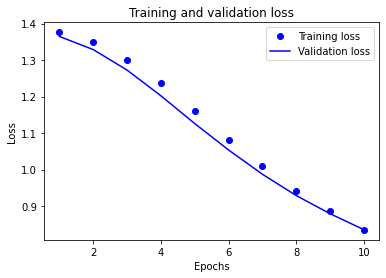

In [100]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

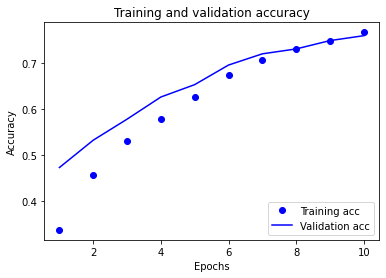

In [101]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## 導出模型

在上面的代碼中，您在將文本輸入模型之前將“TextVectorization”層應用於數據集。如果你想讓你的模型能夠處理原始字符串（例如，為了簡化它的部署），你可以在你的模型中包含 `TextVectorization` 層。為此，您可以使用剛剛訓練的權重創建一個新模型。

In [106]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 8s 28ms/step - loss: 0.8675 - accuracy: 0.7350
0.7350000143051147


### 推斷新數據

要獲得新示例的預測，您可以簡單地調用`model.predict()`。

In [110]:
examples = [
  """
    how to download .msi file in blank i want to download .msi file using blank.
    PrintWriter out = null;
    FileInputStream fileToDownload = null;
    BufferedReader bufferedReader = null;
    try {
            out = response.getWriter();
            fileToDownload = new FileInputStream(DOWNLOAD_DIRECTORY + FILE_NAME);
            bufferedReader = new BufferedReader(new InputStreamReader(fileToDownload));

            //response.setContentType("application/text");
            //response.setContentType("application/x-msi");
            //response.setContentType("application/msi");
            //response.setContentType("octet-stream");
            response.setContentType("application/octet-stream");
            //response.setContentType("application/x-7z-compressed");
            //response.setContentType("application/zip");
            response.setHeader("Content-disposition","attachment; filename=" +FILE_NAME );
            response.setContentLength(fileToDownload.available());

            System.out.println("\n now file download is starting");
            String NextLine = "";
            while((NextLine = bufferedReader.readLine()) != null){
                out.println(NextLine);
            }
            out.flush();                                

        } catch (IOException e) {
            out.write("<center><h2>The Installer is not Available on Server</h2></center>");
            System.out.println("\n Got Exception while getting the input Stream from the file==>"+e);
            log.error("Error::", e);
        }
        finally{
            if(null != bufferedReader){
                try {
                    bufferedReader.close();
                } catch (IOException e) {
                    System.out.println("\n Error in closing buffer Reader==>"+e);
                    log.error("Error::", e);
                }
            }// End of if

            if(null != fileToDownload){
                try {
                    fileToDownload.close();
                } catch (IOException e) {
                    System.out.println("\n Error in closing input stream==>"+e);
                    log.error("Error::", e);
                }
            }// End of if
        }// End of finally       
  """
]

export_model.predict(examples)

1/1 [==============================] - 0s 51ms/step


array([[0.6851961 , 0.88353264, 0.10708151, 0.37060785]], dtype=float32)

In [111]:
examples2 = [
  """
    I am answering a question on LeetCode and I am having a hard time understanding how to code LinkedList (or ListNodes) in blank. I understand the concept of a LinkedList but I still can't understand how to convert a list of integers into a LinkedList of the same!

    I've already tried reading some information on this stuff online and I see there are some recursive options available, but recursion is v.v.costly and I'm not a huge fan of it. Below is LeetCode's implementation of a LinkedList and my way of converting a list into a LinkedList       

    # Definition for singly-linked list.
    # class ListNode(object):
    #     def __init__(self, x):
    #         self.val = x
    #         self.next = None

    list1 = [4,5,1,2,0,4]
    head = ListNode(list1[0])
    e = 1
    while e < len(list1):
          print(head)
          head.next = ListNode(list1[e])
          head = head.next
          e+=1
    return head
  """
]

export_model.predict(examples2)

1/1 [==============================] - 0s 72ms/step


array([[0.4325136 , 0.50241953, 0.3020954 , 0.70581603]], dtype=float32)